<p style='text-align:center'>
PSY 394U <b>Methods for fMRI</b>, Fall 2018


<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Placebo_Left.png?raw=true' alt='brain blobs'/>

</p>

<p style='text-align:center; font-size:40px; margin-bottom: 30px;'><b> fMRI pre-processing </b></p>

<p style='text-align:center; font-size:18px; margin-bottom: 32px;'><b> November 5, 2018</b></p>

<hr style='height:5px;border:none' />

# Overview of pre-processing steps
<hr style="height:1px;border:none" />

We have seen in the previous classes how to normalize structural MRI data to the template space. Starting today, we will learn how to pre-process an fMRI data set so that it will be ready to be analyzed. There are several steps in fMRI pre-processing, and different software tools implement different steps at different stages of preprocessing. Here, my goal is to show some essential steps in pre-processing; whey these steps are needed, and how they can be implemented.

Here are steps of fMRI pre-processing. The order may vary in different software packages, but the idea behind these steps is the same.

  1. **Slice timing correction**: Corrects for the time differences slice acquisition
  2. **Motion correction / realignment**: Corrects for any spatial displacement during fMRI acquisition
  3. **Artifact detection**: Corrects for any physiological artifacts during acquisition
  4. **Co-registration**: Re-orients the image in the same space as the T1-weighted image
  5. **Normalization**: Applies the warping from T1-image normalization to transform fMRI data into the template space
  6. **Spatial smoothing**: Smooth fMRI data with a Gaussian kernel
  7. **Applying a brain mask**: Apply a brain mask so that only the brain voxels are used in the data analysis.

# Slice timing correction
<hr style="height:1px;border:none" />

## What is slice timing correction?

A typical 3D fMRI image is acquired as a series of 2D images, acquired in a certain order.

<img style='width: 400px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Preproc_SliceSeq.png?raw=true' alt='Sequential acquisition'/>

<p style='text-align:center; font-size:14px; margin-bottom: 32px; margin-top: 0px'> <i>Sequential (from top to bottom) </i> </p>


<img style='width: 400px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Preproc_SliceInter.png?raw=true' alt='Interleaved acquisition'/>

<p style='text-align:center; font-size:14px; margin-bottom: 32px; margin-top: 0px'> <i>Interleaved (odd slices, then even slices)</i> </p>

That means there is a delay between the slices acquired first and last, for example. That means these slices are capturing fMRI signal at the different time points. Slice timing correction corrects such differences by signal interpolation and phase shift.


## Slice timing correction or temporal derivatives?

If TR (repetition time - time required to acquire a single volume) is sufficiently short (<2 Sec), then you can correct slice timing differences by including temporal derivatives in your first-level regression model (to be covered later). 

## Slice timing correction with Nipype

Both SPM and FSL have slice timing correction. Here are code snippet examples implementing a slice timing correction for interleaved acquisition. ***They are not complete programs, but code snippets defining a node***.

### FSL

`<SliceTime_fsl.py>`

In [ ]:
from nipype.interfaces import fsl

sliceTime = Node(fsl.slicetimer(interleaved = True,  # interleaved
                                time_repetition = 2.5,  # TR in Sec
                                ),
                 name='sliceTime')

# To connect with other nodes, here are input and output parameters:
#
# input:   in_file
# output:  slice_time_corrected_file
#

It is possible to specify slice order or timing for custom cases (e.g., multi-band acquisition). For more details, please consult **`fsl.slicetimer.help()`**.

### SPM

`<SliceTime_spm.py>`

In [ ]:
from nipype.interfaces import spm

sliceTime = Node(spm.SliceTiming(num_slices = 32,  # number of slices
                                 time_repetition = 2.5,   # TR in sec
                                 time_acquisition = 2.5 - 2.5/32,  # acqu time
                                 slice_order = list(range(31,0,-2))+list(range(32,0,-2)),
                                                   # slice timing, interleaved
                                 ref_slice = 1     # reference slice
                                 )

# To connect with other nodes, here are input and output parameters:
#
# input:   in_files
# output:  timecorrected_files
#

# Motion correction
<hr style="height:1px;border:none" />


## What is motion correction?

Even if you instruct a subject not to move during an fMRI experiment, chances are, he / she is unable to hold absolutely still. In other words, he or she does move the head. So why does it matter if the subject moves the head? That is because signals may not align across time points, and consequently may not be detected.

<img style='width: 500px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Preproc_Motion.png?raw=true' alt='Motion and its impact'/>

To correct this problem, motion correction is performed so that all the time points are spatially aligned. This is typically done by spatially re-orienting each time frame to the reference image. The reference image can be one of the time points (the first time point for SPM, or the middle time point for FSL), or the mean image of all fMRI time points. 

## How is motion correction performed?
Each time point is spatially re-oriented to match the reference image, by rotating or shifting in x, y, and z-directions. This requires only 6 parameters, as opposed to 12 parameters needed for the affine transformation for spatial normalization. This 6-parameter transformation is called **rigid-body transformation**. This makes sense since a person's brain shape does not change over time (at least for the duration of an fMRI experiment anyway), thus scaling and shearing are not needed here. 

<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Preproc_RigidBody.png?raw=true' alt='Rigid body transformation'/>

## Limit of motion correction
If motion is unusually large, motion correction alone cannot correct all the issues arising from misaligned images. Unfortunately motion is particularly problematic for subject populations whom holding still is challenging (e.g., children, elderly, patients with certain conditions such as Parkinson's disease, ADHD). In such a case, the second line of correction is to include the extent of motion in the statistical analysis (to be covered later). In extreme cases, some time points may be discarded. 

## Motion correction in Nipype

Both FSL and SPM have motion correction capability. Since motion correction is often a required step in fMRI pre-processing, I demonstrate motion correction workflows for both FSL and SPM.

### FSL (McFLIRT)

`<MoCor_fsl.py>`

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)

# Directory where your data set resides. This needs to be customized
#dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

Failed to import duecredit due to No module named 'duecredit'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/bids/grabbids/__init__.py:6: FutureWarning: grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8
  warnings.warn("grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8", FutureWarning)


Here, I am using `ds102` data, subject 26, run 1. The task is the flanker task.

In [3]:
# an fMRI image from one of the subjects (run 1 only)
imagefMRI = layout.get(subject='26',
                       run='1',
                       type='bold',
                       extensions='nii.gz',
                       return_type='file')[0]

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

Now, the first node in the workflow is to delete first 4 time points from the fMRI data. This type of dummy scan removal is done to ensure that magnetic spins reach the equilibrium for stable BOLD fMRI signal. Although this step may not be necessary with newer MRI scanners, I just want to demonstrate how to do this using FSL's **`ExtractROI`**. 

In [4]:
# skip dummy scans
extract = Node(fsl.ExtractROI(in_file=imagefMRI,  # input image
                              t_min=4,            # first 4 volumes are deleted
                              t_size=-1),
               name="extract")

The actual motion correction is performed by **`MCFLIRT`**. Here, I specify that optional displacement parameters are generated.

In [5]:
# creating motion correction node
mcflirt = Node(fsl.MCFLIRT(save_rms=True),   # saving displacement parameters
               name="mcflirt")


Then I create a data sink node, workflow, and connecting the nodes in the workflow.

In [6]:
# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

# creating a workflow
moCor = Workflow(name="MoCorFSL", base_dir=outDir)

# connecting the nodes
moCor.connect(extract,'roi_file', mcflirt, 'in_file')
moCor.connect(mcflirt,'out_file', datasink, 'McFSL_Output.@mcfMRI')  # corrected fMRI
moCor.connect(mcflirt,'par_file', datasink, 'McFSL_Output.@mcPar')   # motion parameter
moCor.connect(mcflirt,'rms_files', datasink, 'McFSL_Output.@mcRMS')   # relative motion


Just for fun, I am visualizing the workflow.

In [8]:
%matplotlib inline

181105-14:32:47,986 nipype.workflow INFO:
	 Generated workflow graph: /Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/MoCorFSL/graph_orig.png (graph2use=orig, simple_form=True).


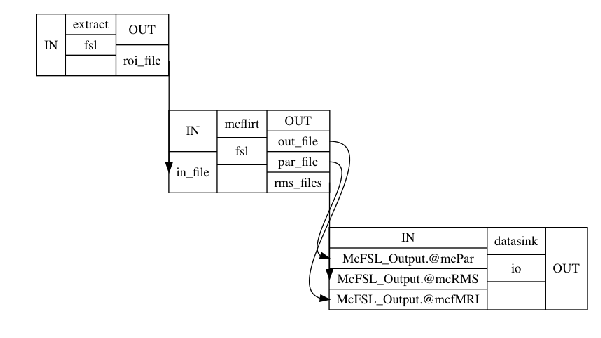

In [8]:
# writing out graph
moCor.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[10,10])
img=mpimg.imread(os.path.join(outDir,"MoCorFSL","graph_orig_detailed.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

And running the workflow.

In [9]:
# running the workflow
moCor.run()

181105-14:33:11,198 nipype.workflow INFO:
	 Workflow MoCorFSL settings: ['check', 'execution', 'logging', 'monitoring']
181105-14:33:11,206 nipype.workflow INFO:
	 Running serially.
181105-14:33:11,207 nipype.workflow INFO:
	 [Node] Setting-up "MoCorFSL.extract" in "/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/MoCorFSL/extract".
181105-14:33:11,211 nipype.workflow INFO:
	 [Node] Cached "MoCorFSL.extract" - collecting precomputed outputs
181105-14:33:11,212 nipype.workflow INFO:
	 [Node] "MoCorFSL.extract" found cached.
181105-14:33:11,213 nipype.workflow INFO:
	 [Node] Setting-up "MoCorFSL.mcflirt" in "/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/MoCorFSL/mcflirt".
181105-14:33:11,217 nipype.workflow INFO:
	 [Node] Cached "MoCorFSL.mcflirt" - collecting precomputed outputs
181105-14:33:11,218 nipype.workflow INFO:
	 [Node] "MoCorFSL.mcflirt" found cached.
181105-14:33:11,219 nipype.workflow INFO:
	 [Node] Setting-up "MoCorFSL.

**Examining the output**

  * Movies of before and after motion correction

### SPM
In SPM, motion correction is referred as **realignment**.

`<MoCor_spm.py>`

In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.spm as spm # importing SPM interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms.misc import Gunzip  # gunzip interface
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)

# Directory where your data set resides. This needs to be customized
#dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an fMRI image from one of the subjects (run 1 only)
imagefMRI = layout.get(subject='26',
                       run='1',
                       type='bold',
                       extensions='nii.gz',
                       return_type='file')[0]

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

Since SPM does not like `nii.gz`, the first node is for `gunzip`. There is no simple way to remove dummy scans in SPM, so I do not do that here.

In [11]:
# gunzip node
gunzip = Node(Gunzip(in_file=imagefMRI),
              name="gunzip")

And the node for the realignment (or motion correction):

In [12]:
# motion correction aka realignment
realign = Node(spm.Realign(),
               name="realign")

The data sink, workflow, and connecting nodes.

In [13]:
# DataSink to collect outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

# creating a workflow
moCor = Workflow(name="MoCorSPM", base_dir=outDir)

# connecting the nodes
moCor.connect(gunzip,'out_file', realign, 'in_files')
moCor.connect(realign,'realigned_files', datasink, 'McSPM_Output.@mcfMRI')  # corrected fMRI
moCor.connect(realign,'realignment_parameters', datasink, 'McSPM_Output.@mcPar')   # motion parameter

As in FSL motion correction, I generate a graph of the workflow.

In [1]:
%matplotlib inline

181105-14:44:19,408 nipype.workflow INFO:
	 Generated workflow graph: /Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/MoCorSPM/graph_orig.png (graph2use=orig, simple_form=True).


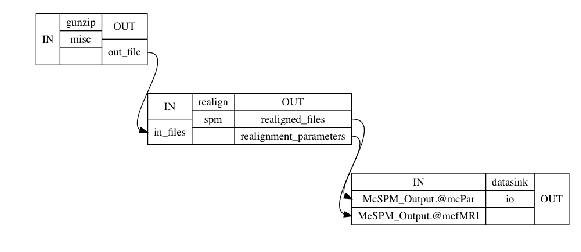

In [15]:
# writing out graphs
moCor.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[10,4])
img=mpimg.imread(os.path.join(outDir,"MoCorSPM","graph_orig_detailed.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Finally running the workflow.

In [16]:
# running the workflow
moCor.run()

181105-14:44:36,759 nipype.workflow INFO:
	 Workflow MoCorSPM settings: ['check', 'execution', 'logging', 'monitoring']
181105-14:44:36,767 nipype.workflow INFO:
	 Running serially.
181105-14:44:36,768 nipype.workflow INFO:
	 [Node] Setting-up "MoCorSPM.gunzip" in "/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/MoCorSPM/gunzip".
181105-14:44:36,772 nipype.workflow INFO:
	 [Node] Cached "MoCorSPM.gunzip" - collecting precomputed outputs
181105-14:44:36,773 nipype.workflow INFO:
	 [Node] "MoCorSPM.gunzip" found cached.
181105-14:44:36,773 nipype.workflow INFO:
	 [Node] Setting-up "MoCorSPM.realign" in "/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/MoCorSPM/realign".
181105-14:44:36,779 nipype.workflow INFO:
	 [Node] Cached "MoCorSPM.realign" - collecting precomputed outputs
181105-14:44:36,780 nipype.workflow INFO:
	 [Node] "MoCorSPM.realign" found cached.
181105-14:44:36,781 nipype.workflow INFO:
	 [Node] Setting-up "MoCorSPM.data

**Examining the output**

  * Movies of before and after motion correction

### Exercise
1. **Plotting motion parameters**. In the motion parameter files generated in the data sink, the first 3 columns correspond to shifts in the x-, y-, and z-directions. The last 3 columns correspond to rotations around the x-, y-, and z-axes. Generate a plot for the shift parameters over time, in a single plot with 3 lines overlaid. Likewise, generate a plot for the rotation parameters over time, in a single plot with 3 lines overlaid. Post the code on Canvas.

2. **Jumpy time points**.

    **2a. (FSL users)** Plot the absolute and relative RMS displacement parameters over time. Are there any time points with a large movement? Post the code on Canvas.

    **2b. (SPM users)** Calculate the RMS (root mean square) displacement parameter by squaring the six parameters at each time point, summing them, then taking a square root. Then calculate the relative displacement by taking a difference between each time point of the RMS parameter and the subsequent data point. This can be easily accomplished by **`np.diff`** function. Then plot the relative displacement parameter over time. Are there any time points with a large movement? Post the code on Canvas.

# Artifact detection
<hr style="height:1px;border:none" />

In addition to motion, two other major sources of confounding factors that may influence the quality of fMRI data are the cardiac cycle (a.k.a., heartbeat) and respiration. Both sources produce periodic signals. Although the frequency of the cardiac signal is much higher than the fMRI sampling frequency, its higher harmonics may be detected by fMRI. Respiration is much slower than TR, so it may be detected by fMRI. 

If you are seriously concerned about these physiological noises, then you can record cardiac cycles and respiration during your fMRI experiment and correct those as part of the fMRI preprocessing steps. 

One popular tool for this is **RETROICOR** in the **AFNI** package. You can use this in Nipype as **`Retroicor`** in **`nipype.interfaces.afni`**. For those who are interested in this should consult AFNI documentation.

# Co-registration
<hr style="height:1px;border:none" />

## What is co-registration?
It is highly likely that your fMRI data initially are not in the same orientation as the accompanying T1-weighted image. The **co-registration** process re-orient your fMRI data in the same orientation as the T1-weighted image. Doing so facilitates normalization of fMRI data, as we see later. 

Co-registration of fMRI data to T1 image data is often done with rigid-body transformation, similar to motion correction. This is because we only need to correct the orientation of fMRI data, but not the shape of fMRI data.

## Co-registration in Nipype

### FSL (FLIRT)
Co-registration in FSL can be accomplished by FLIRT in FSL. But we have to run FLIRT twice: the first FLIRT estimates co-registration parameters, and the second FLIRT applies normalization parameters to all time points. Here in the example code below, I am tacking on the co-registration to the motion-correction workflow I generated earlier, although the data set is different now (`ds114` instead of `ds102`). 

`<CoReg_fsl.py>`

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)

# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds114'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an fMRI image from one of the subjects (finger foot lips, test)
imagefMRI = layout.get(subject='09',
                       session='test',
                       type='bold',
                       task='fingerfootlips',
                       extensions='nii.gz',
                       return_type='file')[0]

# an T1 image for the same subject (test)
imageT1 = layout.get(subject='09',
                     session='test',
                     type='T1w',
                     extensions='nii.gz',
                     return_type='file')[0]

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

Here, I will be using both T1 data and fMRI data (`fingerfootlips` task). Let's create nodes for skipping dummy scans.

In [2]:
# skip dummy scans
extract = Node(fsl.ExtractROI(in_file=imagefMRI,  # input image
                              t_min=4,            # first 4 volumes are deleted
                              t_size=-1),
               name="extract")

Here, McFLIRT is slightly different. We are using the mean fMRI time series as the reference. This forces McFLIRT to produce a mean image as the output (to be used later).

In [3]:
# creating motion correction node
mcflirt = Node(fsl.MCFLIRT(save_rms=True,   # saving displacement parameters
                           mean_vol=True),  # saving mean image
               name="mcflirt")

Now, the first FLIRT node, referred as **`coreg`**. This FLIRT node estimates a rigid-body transformation necessary to match the functional image to the T1-weighted image in the native space.

In [4]:
# creating co-registration node (estimating the coregistration parameters)
coreg = Node(fsl.FLIRT(reference=imageT1,  # target: T1-weighted
                       dof=6,       # specifying rigid-body (6-parameters)
                       cost='normmi'), # normizied mutual info
             name="coreg")

One thing to note here is that I am using **`cost='normmi'`**, or the cost function is normalized mutual information. Since the structural image (T1-weighted) and the functional image (T2*-weighted) have different contrasts, it makes sense to use an information theory-based cost function.

The second FLIRT node, referred as **`applywarp`**. This node applies the rigid-body transformation estimated from the previous FLIRT node and transform all the time points in the fMRI time series.

In [5]:
# applying the coregistration parameters to the entire time series
applywarp = Node(fsl.FLIRT(reference=imageT1,
                           apply_isoxfm=4),  # forcing the voxel size = 4mm
                 name="applywarp")

Here we have to use the T1 image as the reference image, since the parameters estimated from the first FLIRT is the transformation to T1. We also specify **`apply_isoxfm=4`**. This means the output image is generated by isotropic sampling (i.e., voxel size with the same width, depth, and height) specifying that the voxel size is 4 x 4 x 4 mm.

Let's create a data sink and a workflow object.

In [6]:
# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

# creating a workflow
coReg = Workflow(name="CoRegFSL", base_dir=outDir)

Now connecting nodes. 

In [7]:
# connecting the nodes
coReg.connect(extract,'roi_file', mcflirt, 'in_file')
# mcflirt fMRI as input for the first FLIRT
coReg.connect([(mcflirt, coreg, [('mean_img', 'in_file')])])  
# mcflirt fMRI as input for the second FLIRT
coReg.connect([(mcflirt, applywarp, [('out_file', 'in_file')])]) 
# and passing on the rigid-body transformation parameters from first FLIRT
coReg.connect([(coreg, applywarp, [('out_matrix_file', 'in_matrix_file')])])
# second FLIRT node to data sink
coReg.connect([(applywarp, datasink, [('out_file', 'FSLCoReg')])])

Note that the rigid-body transformation parameters from the first FLIRT (**`out_matrix_file`**) is used in the `applywarp` node to apply the transformation to the rest of fMRI time series data.

For fun, let's see the workflow diagram.

181109-10:48:43,373 nipype.workflow INFO:
	 Generated workflow graph: /home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/CoRegFSL/graph_orig.png (graph2use=orig, simple_form=True).


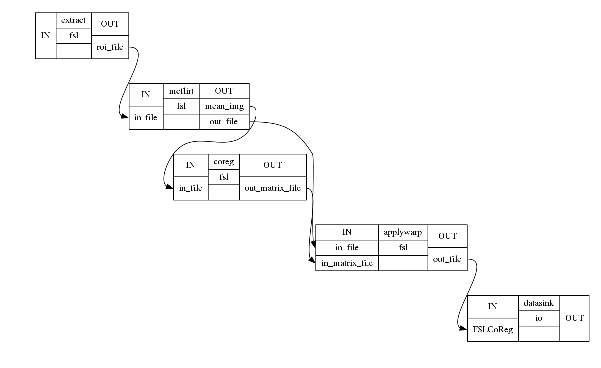

In [9]:
# writing out graph
coReg.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[10,10])
img=mpimg.imread(os.path.join(outDir,"CoRegFSL","graph_orig_detailed.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Now let's run the workflow!

In [10]:
# running the workflow
coReg.run()

181109-10:49:27,730 nipype.workflow INFO:
	 Workflow CoRegFSL settings: ['check', 'execution', 'logging', 'monitoring']
181109-10:49:27,744 nipype.workflow INFO:
	 Running serially.
181109-10:49:27,746 nipype.workflow INFO:
	 [Node] Setting-up "CoRegFSL.extract" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/CoRegFSL/extract".
181109-10:49:27,751 nipype.workflow INFO:
	 [Node] Cached "CoRegFSL.extract" - collecting precomputed outputs
181109-10:49:27,753 nipype.workflow INFO:
	 [Node] "CoRegFSL.extract" found cached.
181109-10:49:27,755 nipype.workflow INFO:
	 [Node] Setting-up "CoRegFSL.mcflirt" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/CoRegFSL/mcflirt".
181109-10:49:27,759 nipype.workflow INFO:
	 [Node] Outdated cache found for "CoRegFSL.mcflirt".
181109-10:49:27,774 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/satoru/Teaching/fMRI_Fa

**Examining the output**

  * MRIcron overlay: T1 (native) in the background, with co-registered fMRI overlaid

### SPM (Coregister)
Co-registration in SPM can be accomplished by **Coregister**. First, we have to gunzip the T1-weighted image as well as the fMRI data. Unlike FSL, SPM's co-registration process can do everything in one step. Here in the example code below, I am tacking on the co-registration to the motion-correction workflow I generated earlier, although the data set is different now (`ds114` instead of `ds102`). 

In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.spm as spm # importing SPM interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms.misc import Gunzip  # gunzip interface
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)

# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds114'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an fMRI image from one of the subjects (finger foot lips, test)
imagefMRI = layout.get(subject='09',
                       session='test',
                       type='bold',
                       task='fingerfootlips',
                       extensions='nii.gz',
                       return_type='file')[0]

# an T1 image for the same subject (test)
imageT1 = layout.get(subject='09',
                     session='test',
                     type='T1w',
                     extensions='nii.gz',
                     return_type='file')[0]

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

First, two `gunzip` nodes for T1-weighted and fMRI, then a motion correction node.

In [12]:
# gunzip nodes
gunzip_T1w = Node(Gunzip(in_file=imageT1),
              name="gunzip_T1w")

gunzip_fMRI = Node(Gunzip(in_file=imagefMRI),
              name="gunzip_fMRI")



# motion correction aka realignment
realign = Node(spm.Realign(),
               name="realign")

And the co-registration node with **`spm.Coregister`**. Here, I am specifying the cost function **`cost_function='nmi'`**, where `nmi` stands for normalized mutual information. 

In [13]:
# co-registration node
coreg = Node(spm.Coregister(cost_function='nmi',
                            jobtype='estimate'),
             name="coreg")

A data sink, a workflow, and connecting nodes. 

In [14]:
# DataSink to collect outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

# creating a workflow
coReg = Workflow(name="CoRegSPM", base_dir=outDir)

# connecting the nodes
coReg.connect(gunzip_fMRI,'out_file', realign, 'in_files')
coReg.connect([(gunzip_T1w, coreg, [('out_file', 'target')])])  
coReg.connect([(realign, coreg, [('mean_image', 'source')])])
coReg.connect([(realign, coreg, [('realigned_files', 'apply_to_files')])])
coReg.connect([(coreg, datasink, [('coregistered_files', 'SPMCoReg')])])

Let's take a look at the workflow diagram.

181109-10:52:45,424 nipype.workflow INFO:
	 Generated workflow graph: /home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/CoRegSPM/graph_orig.png (graph2use=orig, simple_form=True).


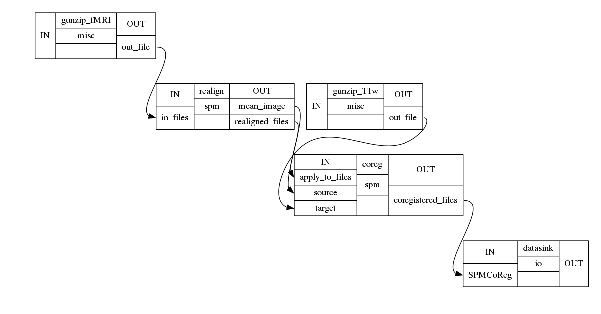

In [15]:
# writing out graphs
coReg.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[10,6])
img=mpimg.imread(os.path.join(outDir,"CoRegSPM","graph_orig_detailed.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [16]:
# running the workflow
coReg.run()

181109-10:52:49,70 nipype.workflow INFO:
	 Workflow CoRegSPM settings: ['check', 'execution', 'logging', 'monitoring']
181109-10:52:49,82 nipype.workflow INFO:
	 Running serially.
181109-10:52:49,84 nipype.workflow INFO:
	 [Node] Setting-up "CoRegSPM.gunzip_T1w" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/CoRegSPM/gunzip_T1w".
181109-10:52:49,90 nipype.workflow INFO:
	 [Node] Cached "CoRegSPM.gunzip_T1w" - collecting precomputed outputs
181109-10:52:49,91 nipype.workflow INFO:
	 [Node] "CoRegSPM.gunzip_T1w" found cached.
181109-10:52:49,93 nipype.workflow INFO:
	 [Node] Setting-up "CoRegSPM.gunzip_fMRI" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/CoRegSPM/gunzip_fMRI".
181109-10:52:49,99 nipype.workflow INFO:
	 [Node] Cached "CoRegSPM.gunzip_fMRI" - collecting precomputed outputs
181109-10:52:49,100 nipype.workflow INFO:
	 [Node] "CoRegSPM.gunzip_fMRI" found cached.
181109-10:52:49,102 nipype.workflow INFO:
	 [Node] Setting-up "CoRegSPM.rea

**Examining the output**

  * MRIcron overlay: T1 (native) in the background, with co-registered fMRI overlaid
  * fslview: Co-registration results from FSL and SPM. Notice the blurriness.

# Normalization, smoothing, brain mask
<hr style="height:1px;border:none" />

## Normalization

Now that an fMRI data set is in the same space as the accompanying T1-weighted image after co-registration, one can normalize the fMRI data to the template space. This is done by applying warping parameters from the normalization of T1 to the template, to the fMRI data. 

<img style='width: 700px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Preproc_Norm.png?raw=true' alt='Normalization of fMRI'/>

Why can't we normalize the fMRI data directly to the template? That is because fMRI data tend to be blurry and have poor contrast; consequently the direct normalization to the template would result in a sub-optimal outcome. 

Normalization does not have to occur at this stage of fMRI data pre-processing. In fact, in FSL, fMRI data are never normalized; only the outcome from the first-level analysis (i.e., subject-level analysis) is normalized to the template. On the other hand, SPM is designed so that fMRI data are normalized to the template when a T1 image is normalized. For this class, I normalize fMRI data for both FSL and SPM pre-processing pipelines, so that we can start the first-level analysis from the normalized fMRI data. 


## Smoothing

It is a common practice to smooth (or intentionally blur) fMRI data before data analyses. This is done by applying a 3D Gaussian filter. 

<img style='width: 600px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Preproc_Smooth.png?raw=true' alt='Smoothing MRI'/>

**Why do we smooth fMRI data?** There are several reasons:
  * To correct for imperfection in normalization
  * Smooth out spatial noises (salt & pepper noises)
  * Improve signal detection
  * Statistical methods (random field theory) work better if data are smooth
  
**How much smoothing?** The degree of smoothing is described by the width of the Gaussian filter, summarized by the FWHM (full-width at half-maximum). In terms of the standard deviation $\sigma$, $FWHM=\sqrt{8 \ln 2} \sigma$. The rule of thumb is about 2-3 times the voxel size. 


## Masking

After normalized and smoothed, fMRI data can be masked to eliminate any non-brain voxels. This is to limit the inclusion of non-brain voxels in analyses to lessen the impact of a multiple comparison correction. Since fMRI data is in the template space at this point, I am using the brain mask image provided by FSL or SPM. However, the proper way of constructing a brain mask is to use the subject's segmented image.



## Example (FSL)

The following is the full pre-processing script, including the normalization, smoothing, and masking nodes. I am analyzing the finger foot lips task fMRI data from subject 09 from the `ds114` data, from the `test` session.

`<FullPreproc_fsl.py>`

In [1]:
# Only for those using Jupyter notebook
%matplotlib inline

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)

# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds114'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an fMRI image from one of the subjects (finger foot lips, test)
imagefMRI = layout.get(subject='09',
                       session='test',
                       type='bold',
                       task='fingerfootlips',
                       extensions='nii.gz',
                       return_type='file')[0]

# an T1 image for the same subject (test)
imageT1 = layout.get(subject='09',
                     session='test',
                     type='T1w',
                     extensions='nii.gz',
                     return_type='file')[0]

Here are the MNI template image, as well as the whole-brain mask image from FSL.

In [4]:
# template image (from FSL)
fMNI = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

# brain mask in MNI space (from FSL)
fmask = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'


# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

At this point, I included some lines of code from the normalization workflow of a T1-weighted image, called **`normT1wf`**.

In [5]:
#
#    T1 Normalization workflow
#
# Skullstrip process node
fslBET = Node(fsl.BET(in_file=imageT1), 
              name="fslBET")


# Linear normalization node
fslFLIRT = Node(fsl.FLIRT(reference=fMNI,
                          cost_func='normmi'),
                name="fslFLIRT")

# Non-linear normalization node
fslFNIRT = Node(fsl.FNIRT(ref_file=fMNI,
                          fieldcoeff_file=True),
                name='fslFNIRT')

# Creating a workflow object
normT1wf = Workflow(name="fslNorm_T1", base_dir=outDir)

# connecting nodes as a T1 normalization workflow
normT1wf.connect(fslBET, "out_file", fslFLIRT, "in_file")
normT1wf.connect([(fslBET, fslFNIRT, [('out_file', 'in_file')]),
                  (fslFLIRT,fslFNIRT, [('out_matrix_file', 'affine_file')])])


Now the fMRI pre-processing workflow. For the co-registration step, two nodes are still necessary. However, during the `applywarp` node, in addition to the linear parameters, I am including non-linear parameters to describe the warp between the native space (of T1 data) to the template space.

In [6]:
#
#   fMRI pre-processing
#
# skip dummy scans
extract = Node(fsl.ExtractROI(in_file=imagefMRI,  # input image
                              t_min=4,            # first 4 volumes are deleted
                              t_size=-1),
               name="extract")

# creating motion correction node
mcflirt = Node(fsl.MCFLIRT(save_rms=True,   # saving displacement parameters
                           mean_vol=True),  # saving mean image
               name="mcflirt")

# creating co-registration node (estimating the coregistration parameters)
coreg = Node(fsl.FLIRT(dof=6,       # specifying rigid-body (6-parameters)
                       cost='normmi'), # normizied mutual info
             name="coreg")

# applying the coregistration and normalization parameters to fMRI data
applywarp = Node(fsl.ApplyWarp(ref_file=fMNI), 
                 name="applywarp")

Smoothing is applied by **`SUSAN`** in FSL. Here, the smoothing filter is isotropic (i.e., identical in x-, y-, and z-directions) **`fwhm=6.0`**mm. 

In [7]:
# smoothing with SUSAN
susan = Node(fsl.SUSAN(brightness_threshold = 2000.0,  # brightness threshold
                       fwhm=6.0),    # smoothing filter width (6mm, isotropic)
             name='susan')

Then applying the whole-brain mask with **`ApplyMask`**.

In [8]:
# masking the fMRI with a brain mask
applymask = Node(fsl.ApplyMask(mask_file=fmask),
                 name='applymask')

Then creating a datasink, the main workflow for fMRI pre-processing, and making connections.

In [9]:
# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

# creating a workflow
preporcfMRI = Workflow(name="PreprocfMRI_FSL", base_dir=outDir)

# connecting the nodes to the main workflow
preporcfMRI.connect([(extract, mcflirt, [('roi_file', 'in_file')])])  
preporcfMRI.connect([(mcflirt, coreg, [('mean_img', 'in_file')])])  
preporcfMRI.connect([(normT1wf, coreg, [('fslBET.out_file', 'reference')])])  
preporcfMRI.connect([(mcflirt, applywarp, [('out_file', 'in_file')])]) 
preporcfMRI.connect([(coreg, applywarp, [('out_matrix_file', 'premat')])])
preporcfMRI.connect([(normT1wf, applywarp, [('fslFNIRT.fieldcoeff_file', 
                                             'field_file')])])
preporcfMRI.connect([(applywarp, susan, [('out_file', 'in_file')])])
preporcfMRI.connect([(susan, applymask, [('smoothed_file', 'in_file')])])

# connection to data sink
preporcfMRI.connect([(mcflirt, datasink, [('par_file', 
                                           'FSL_Preproc_fMRI.@McFLIRTPar')])])
preporcfMRI.connect([(mcflirt, datasink, [('rms_files', 
                                           'FSL_Preproc_fMRI.@McFLIRTRms')])])
preporcfMRI.connect([(normT1wf, datasink, [('fslFNIRT.warped_file', 
                                            'FSL_Preproc_fMRI.@NormT1')])])
preporcfMRI.connect([(applywarp, datasink, [('out_file', 
                                             'FSL_Preproc_fMRI.@NormfMRI')])])
preporcfMRI.connect([(applymask, datasink, [('out_file', 
                                             'FSL_Preproc_fMRI.@MaskSmoNormfMRI')])])

One thing to note here is that you can include another workflow in a similar way as including a node. To refer a particular input or output parameter, you need to specify a node, then the parameter name. For example:
```Python
preporcfMRI.connect([(normT1wf, coreg, [('fslBET.out_file', 'reference')])])  
```
Here, the output parameter **`out_file`** from the node **`fslBET`** in the workflow **`normT1wf`** is connected to the input **`reference`** in the node **`coreg`**.

Now all the nodes are connected. Let's take a look at the workflow.

181112-11:53:09,615 nipype.workflow INFO:
	 Generated workflow graph: /home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_FSL/graph_orig.png (graph2use=orig, simple_form=True).


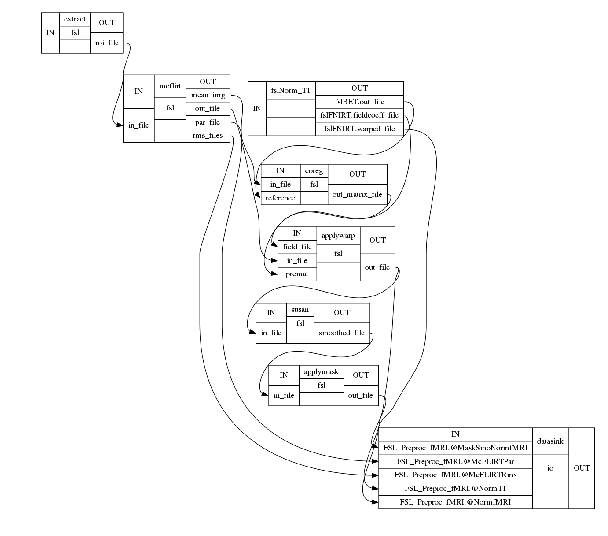

In [10]:
# writing out graph
preporcfMRI.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[10,10])
img=mpimg.imread(os.path.join(outDir,"PreprocfMRI_FSL","graph_orig_detailed.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

And actually running the workflow. It may take 10 minutes or so, depending on your computer.

In [11]:
# running the workflow
preporcfMRI.run()

181112-11:54:27,330 nipype.workflow INFO:
	 Workflow PreprocfMRI_FSL settings: ['check', 'execution', 'logging', 'monitoring']
181112-11:54:27,345 nipype.workflow INFO:
	 Running serially.
181112-11:54:27,346 nipype.workflow INFO:
	 [Node] Setting-up "PreprocfMRI_FSL.fslNorm_T1.fslBET" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_FSL/fslNorm_T1/fslBET".
181112-11:54:27,352 nipype.workflow INFO:
	 [Node] Running "fslBET" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/sub-09/ses-test/anat/sub-09_ses-test_T1w.nii.gz /home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_FSL/fslNorm_T1/fslBET/sub-09_ses-test_T1w_brain.nii.gz
181112-11:54:31,493 nipype.workflow INFO:
	 [Node] Finished "PreprocfMRI_FSL.fslNorm_T1.fslBET".
181112-11:54:31,495 nipype.workflow INFO:
	 [Node] Setting-up "PreprocfMRI_FSL.fslNorm_T1.fslFLIRT" in "/home/satoru/Teaching/fMRI_Fall

## Example (SPM)

Here is the full pre-processing workflow, now with SPM. It analyzes the same data as FSL. This workflow does not have the brain mask node, since such an interface is not readily available in SPM.

`<FullPreproc_spm.py>`

In [12]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.spm as spm # importing SPM interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms.misc import Gunzip  # gunzip interface
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)

# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds114'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an fMRI image from one of the subjects (finger foot lips, test)
imagefMRI = layout.get(subject='09',
                       session='test',
                       type='bold',
                       task='fingerfootlips',
                       extensions='nii.gz',
                       return_type='file')[0]

# an T1 image for the same subject (test)
imageT1 = layout.get(subject='09',
                     session='test',
                     type='T1w',
                     extensions='nii.gz',
                     return_type='file')[0]

Needless to say, the template is from SPM.

In [13]:
# template (it has to be tissue probability maps)
#fTPM = '/Users/sh45474/SoftwareTools/spm12/tpm/TPM.nii'
fTPM = '/usr/local/spm12/tpm/TPM.nii'

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

Here is the T1-image normalization workflow.

In [14]:
#
#    T1 Normalization nodes
#
# gunzip node
gunzip_T1w = Node(Gunzip(in_file=imageT1),
              name="gunzip_T1w")

# Normalize - normalizes structural images to the MNI template
normalize = Node(spm.Normalize12(jobtype='estwrite',
                                 tpm=fTPM,
                                 write_bounding_box=[[-90, -120, -70],
                                                     [90, 90, 105]]),
                 name="normalize")


And fMRI pre-processing workflow nodes.

In [15]:
#
#   fMRI pre-processing
#
# gunzip node
gunzip_fMRI = Node(Gunzip(in_file=imagefMRI),
              name="gunzip_fMRI")

# motion correction aka realignment
realign = Node(spm.Realign(),
               name="realign")

# co-registration node
coreg = Node(spm.Coregister(cost_function='nmi',
                            jobtype='estimate'),
             name="coreg")

I do not need a normalization node for fMRI data per se. I can just feed that information to the normalization node in the T1-normalization workflow. As for smoothing, I try 6mm isotropic (i.e., **`fwhm=[6,6,6]`**). 


In [16]:
# smoothing node
smooth = Node(spm.Smooth(fwhm=[6,6,6]),
              name='smooth')

Then creating a datasink, the main workflow for fMRI pre-processing, and making connections.

In [17]:
# DataSink to collect outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

# creating a workflow
preprocfMRI = Workflow(name="PreprocfMRI_SPM", base_dir=outDir)

# connecting the nodes to the main workflow
preprocfMRI.connect([(gunzip_fMRI, realign, [('out_file', 'in_files')])])  
preprocfMRI.connect([(gunzip_T1w, coreg, [('out_file', 'target')])])  
preprocfMRI.connect([(realign, coreg, [('mean_image', 'source')])])
preprocfMRI.connect([(realign, coreg, [('realigned_files', 'apply_to_files')])])
preprocfMRI.connect([(gunzip_T1w, normalize, [('out_file', 'image_to_align')])])
preprocfMRI.connect([(coreg, normalize, [('coregistered_files', 'apply_to_files')])])
preprocfMRI.connect([(normalize, smooth, [('normalized_files', 'in_files')])])
# connections to the datasink
preprocfMRI.connect([(realign, datasink, [('realignment_parameters', 
                                           'SPM_Preproc_fMRI.@mcPar')])])
preprocfMRI.connect([(normalize, datasink, [('normalized_image', 
                                             'SPM_Preproc_fMRI.@T1_standard')])])
preprocfMRI.connect([(normalize, datasink, [('normalized_files', 
                                             'SPM_Preproc_fMRI.@fMRI_standard')])])
preprocfMRI.connect([(smooth, datasink, [('smoothed_files', 
                                          'SPM_Preproc_fMRI.@SmoothfMRI_standard')])])

Now everything is connected. Let's take a look at the workflow diagram.

181112-12:20:19,606 nipype.workflow INFO:
	 Generated workflow graph: /home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_SPM/graph_orig.png (graph2use=orig, simple_form=True).


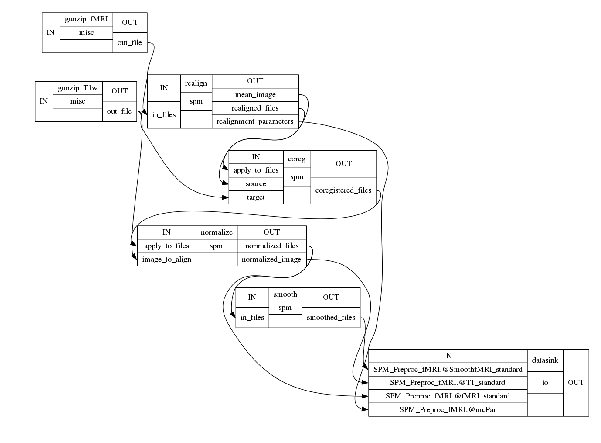

In [20]:
# writing out graphs
preprocfMRI.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[10,10])
img=mpimg.imread(os.path.join(outDir,"PreprocfMRI_SPM","graph_orig_detailed.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Let's run it! This one may be faster than the FSL counterpart.

In [21]:
# running the workflow
preprocfMRI.run()

181112-12:21:12,223 nipype.workflow INFO:
	 Workflow PreprocfMRI_SPM settings: ['check', 'execution', 'logging', 'monitoring']
181112-12:21:12,241 nipype.workflow INFO:
	 Running serially.
181112-12:21:12,243 nipype.workflow INFO:
	 [Node] Setting-up "PreprocfMRI_SPM.gunzip_T1w" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_SPM/gunzip_T1w".
181112-12:21:12,249 nipype.workflow INFO:
	 [Node] Running "gunzip_T1w" ("nipype.algorithms.misc.Gunzip")
181112-12:21:12,550 nipype.workflow INFO:
	 [Node] Finished "PreprocfMRI_SPM.gunzip_T1w".
181112-12:21:12,551 nipype.workflow INFO:
	 [Node] Setting-up "PreprocfMRI_SPM.gunzip_fMRI" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_SPM/gunzip_fMRI".
181112-12:21:12,554 nipype.workflow INFO:
	 [Node] Running "gunzip_fMRI" ("nipype.algorithms.misc.Gunzip")
181112-12:21:13,10 nipype.workflow INFO:
	 [Node] Finished "PreprocfMRI_SPM.gunzip_fMRI".
181112-12:21:13,12 nipype.workflow INFO:
	

**Examining the output**

  * fslview: Pipeline results from FSL and SPM. Normalized T1 in the background, normalized fMRI in the foreground.

# Hybrid pre-processing pipeline
<hr style="height:1px;border:none" />

So far, we have seen the strengths and weaknesses of FSL and SPM pre-processing steps. Although, if we choose to, we can construct a pre-processing pipeline solely with FSL or solely with SPM. However, Nipype enables us to combine data processing steps from different packages. So, here, I demonstrate a combined pre-processing pipeline. This pipeline consists of:

  1. Dropping dummy scans (FSL)
  2. Motion correction (SPM)
  3. Co-registration (SPM)
  4. Normalization (SPM)
  5. Smoothing (SPM)
  6. Applying brain mask (FSL)
 

`<FullPreproc_combo.py>`

181112-12:54:00,318 nipype.workflow INFO:
	 Generated workflow graph: /home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_combo/graph_orig.png (graph2use=orig, simple_form=True).


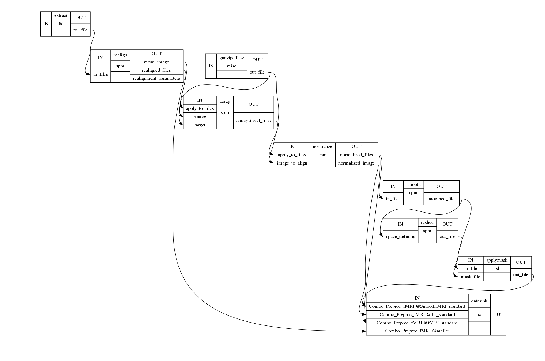

181112-12:54:00,679 nipype.workflow INFO:
	 Workflow PreprocfMRI_combo settings: ['check', 'execution', 'logging', 'monitoring']
181112-12:54:00,699 nipype.workflow INFO:
	 Running serially.
181112-12:54:00,701 nipype.workflow INFO:
	 [Node] Setting-up "PreprocfMRI_combo.gunzip_T1w" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_combo/gunzip_T1w".
181112-12:54:00,705 nipype.workflow INFO:
	 [Node] Running "gunzip_T1w" ("nipype.algorithms.misc.Gunzip")
181112-12:54:00,956 nipype.workflow INFO:
	 [Node] Finished "PreprocfMRI_combo.gunzip_T1w".
181112-12:54:00,958 nipype.workflow INFO:
	 [Node] Setting-up "PreprocfMRI_combo.extract" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/WorkflowOutput/PreprocfMRI_combo/extract".
181112-12:54:00,963 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /home/satoru/Teaching/fMRI_Fall_2018/Data/ds114/sub-09/ses-test/func/sub-09_s

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.spm as spm # importing SPM interface functions
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms.misc import Gunzip  # gunzip interface
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)

# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds114'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds114'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an fMRI image from one of the subjects (finger foot lips, test)
imagefMRI = layout.get(subject='09',
                       session='test',
                       type='bold',
                       task='fingerfootlips',
                       extensions='nii.gz',
                       return_type='file')[0]

# an T1 image for the same subject (test)
imageT1 = layout.get(subject='09',
                     session='test',
                     type='T1w',
                     extensions='nii.gz',
                     return_type='file')[0]

# template (it has to be tissue probability maps)
#fTPM = '/Users/sh45474/SoftwareTools/spm12/tpm/TPM.nii'
fTPM = '/usr/local/spm12/tpm/TPM.nii'

# brain mask in MNI space (from SPM)
#fmask = '/Users/sh45474/SoftwareTools/spm12/tpm/mask_ICV.nii'
fmask = '/usr/local/spm12/tpm/mask_ICV.nii'


# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')




#
#    T1 Normalization nodes
#
# gunzip node
gunzip_T1w = Node(Gunzip(in_file=imageT1),
              name="gunzip_T1w")

# Normalize - normalizes structural images to the MNI template
normalize = Node(spm.Normalize12(jobtype='estwrite',
                                 tpm=fTPM,
                                 write_bounding_box=[[-90, -120, -70],
                                                     [90, 90, 105]]),
                 name="normalize")





#
#   fMRI pre-processing
#
# skip dummy scans
extract = Node(fsl.ExtractROI(in_file=imagefMRI,  # input image
                              t_min=4,            # first 4 volumes are deleted
                              t_size=-1,
                              output_type='NIFTI'),  # forces output to be .nii
               name="extract")

# motion correction aka realignment
realign = Node(spm.Realign(),
               name="realign")

# co-registration node
coreg = Node(spm.Coregister(cost_function='nmi',
                            jobtype='estimate'),
             name="coreg")

# smoothing node
smooth = Node(spm.Smooth(fwhm=[6,6,6]),
              name='smooth')

# Reslice the brain mask to match fMRI
reslice = Node(spm.utils.Reslice(in_file=fmask),  # mask image needs to be resliced
               name='reslice')

# masking the fMRI with a brain mask
applymask = Node(fsl.ApplyMask(),
                 name='applymask')

# DataSink to collect outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

# creating a workflow
preprocfMRI = Workflow(name="PreprocfMRI_combo", base_dir=outDir)

# connecting the nodes to the main workflow
preprocfMRI.connect([(extract, realign, [('roi_file', 'in_files')])])  
preprocfMRI.connect([(gunzip_T1w, coreg, [('out_file', 'target')])])  
preprocfMRI.connect([(realign, coreg, [('mean_image', 'source')])])
preprocfMRI.connect([(realign, coreg, [('realigned_files', 'apply_to_files')])])
preprocfMRI.connect([(gunzip_T1w, normalize, [('out_file', 'image_to_align')])])
preprocfMRI.connect([(coreg, normalize, [('coregistered_files', 'apply_to_files')])])
preprocfMRI.connect([(normalize, smooth, [('normalized_files', 'in_files')])])
preprocfMRI.connect([(smooth, reslice, [('smoothed_files', 'space_defining')])])
preprocfMRI.connect([(reslice, applymask, [('out_file', 'mask_file')])])
preprocfMRI.connect([(smooth, applymask, [('smoothed_files', 'in_file')])])


# connections to the datasink
preprocfMRI.connect([(realign, datasink, [('realignment_parameters', 
                                           'Combo_Preproc_fMRI.@mcPar')])])
preprocfMRI.connect([(normalize, datasink, [('normalized_image', 
                                             'Combo_Preproc_fMRI.@T1_standard')])])
preprocfMRI.connect([(normalize, datasink, [('normalized_files', 
                                             'Combo_Preproc_fMRI.@fMRI_standard')])])
preprocfMRI.connect([(applymask, datasink, [('out_file', 
                                             'Combo_Preproc_fMRI.@SmoothfMRI_standard')])])

# writing out graphs
preprocfMRI.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[10,6])
img=mpimg.imread(os.path.join(outDir,"PreprocfMRI_combo","graph_orig_detailed.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

# running the workflow
preprocfMRI.run()


**Examining the output**

  * fslview: Pipeline results with FSL and SPM. Normalized T1 in the background, normalized fMRI in the foreground.